### Initial setup

In [1]:
#Import libraries
import pandas as pd
from pandas import DataFrame
import numpy as np
from patsy import dmatrices, dmatrix
from scipy import stats
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import theano
import theano.tensor as tt
import arviz as az
import pymc3 as pm

import warnings
warnings.simplefilter(action="ignore")

print("Packages uploaded successfully!")

Packages uploaded successfully!


### Data preparation

In [2]:
#Read data
data = pd.read_csv('./machine_readable_dnt.csv')

In [3]:
#Standardise continuous values
data_prep = data[['SLogP', 'Cbrain/Cblood','Syn_EC30', 
                  'Viability_EC30', 'NNF EC50min', 'NNF EC50max', 'Viability_LDH']]
sc = StandardScaler()
data_scaled = sc.fit_transform(data_prep)
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = ['SLogP', 'Cbrain/Cblood','Syn_EC30', 
                       'Viability_EC30', 'NNF EC50min', 'NNF EC50max', 'Viability_LDH']

#Add other discrete values and details
discrete = data [['ID', 'Chemical', 'CASRN', 'DNT', 'BBB', 'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active', 
  'BDNF, Reduction', 'Activity_Syn', 'Activity_NNF']]
data = discrete.join(data_scaled, lsuffix="_left", rsuffix="_right")

In [4]:
# ### Define predictors and outcomes

#BDNF given by continuous and discrete variables
x_bdnf = pd.DataFrame(data[['SLogP', 'Cbrain/Cblood', 'BBB', 
                            'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active']]).values
y_bdnf = pd.DataFrame(data[['BDNF, Reduction']]).values

#Syn
x_syn = pd.DataFrame(data[['Syn_EC30', 'Viability_EC30']]).values
y_syn = pd.DataFrame(data[['Activity_Syn']]).values

#NNF
x_nnf = pd.DataFrame(data[['NNF EC50min', 'NNF EC50max', 'Viability_LDH']]).values
y_nnf = pd.DataFrame(data[['Activity_NNF']]).values

#x_dnt is given by causal relations BDNF->SYN->NNF->DNT<-BNDF
y_dnt = pd.DataFrame(data[['DNT']]).values

In [5]:
# ### Mask missing values

#BDNF
x_bdnf_missing = np.isnan(x_bdnf)
print(f"BDNF predictor shape={x_bdnf.shape}, contains {x_bdnf_missing.sum()} missing value")
X_bdnf_train = np.ma.masked_array(x_bdnf, mask=x_bdnf_missing)
y_bdnf_missing = np.isnan(y_bdnf)
print(f"BDNF shape={y_bdnf.shape}, contains {y_bdnf_missing.sum()} missing value")
Y_bdnf_train = np.ma.masked_array(y_bdnf, mask=y_bdnf_missing)

#Syn
x_syn_missing = np.isnan(x_syn)
print(f"Syn predictor shape={x_syn.shape}, contains {x_syn_missing.sum()} missing value")
X_syn_train = np.ma.masked_array(x_syn, mask=x_syn_missing)
y_syn_missing = np.isnan(y_syn)
print(f"Syn shape={y_syn.shape}, contains {y_syn_missing.sum()} missing value")
Y_syn_train = np.ma.masked_array(y_syn, mask=y_syn_missing)

#NNF
x_nnf_missing = np.isnan(x_nnf)
print(f"NNF predictor shape={x_nnf.shape}, contains {x_nnf_missing.sum()} missing value")
X_nnf_train = np.ma.masked_array(x_nnf, mask=x_nnf_missing)
y_nnf_missing = np.isnan(y_nnf)
print(f"NNF shape={y_nnf.shape}, contains {y_nnf_missing.sum()} missing value")
Y_nnf_train = np.ma.masked_array(y_nnf, mask=y_nnf_missing)

#DNT
y_dnt_missing = np.isnan(y_dnt)
print(f"DNT shape={y_dnt.shape}, contains {y_dnt_missing.sum()} missing value")
Y_dnt_train = np.ma.masked_array(y_dnt, mask=y_dnt_missing)

BDNF predictor shape=(97, 6), contains 115 missing value
BDNF shape=(97, 1), contains 60 missing value
Syn predictor shape=(97, 2), contains 60 missing value
Syn shape=(97, 1), contains 0 missing value
NNF predictor shape=(97, 3), contains 40 missing value
NNF shape=(97, 1), contains 0 missing value
DNT shape=(97, 1), contains 0 missing value


### Test submodel for predictors

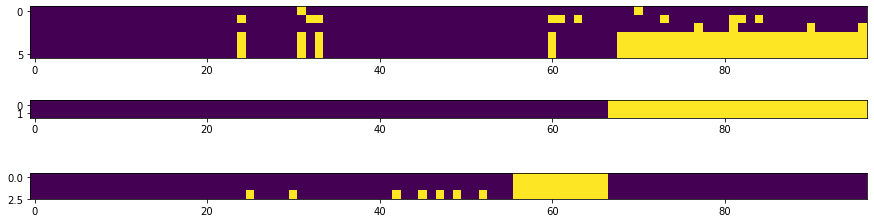

In [6]:
_, ax = plt.subplots(3, 1, figsize=(15, 4))
ax[0].imshow(x_bdnf_missing.T);
ax[1].imshow(x_syn_missing.T);
ax[2].imshow(x_nnf_missing.T);

In [7]:
np.corrcoef(x_bdnf[~np.any(x_bdnf_missing, axis=1), :].T)

array([[ 1.        ,  0.5418384 ,  0.07627183,  0.35512619,  0.07253988,
         0.26954222],
       [ 0.5418384 ,  1.        , -0.06965216, -0.00842625, -0.11163504,
        -0.05831537],
       [ 0.07627183, -0.06965216,  1.        , -0.11224426, -0.21271043,
        -0.04533395],
       [ 0.35512619, -0.00842625, -0.11224426,  1.        ,  0.23798627,
         0.82831537],
       [ 0.07253988, -0.11163504, -0.21271043,  0.23798627,  1.        ,
         0.63705899],
       [ 0.26954222, -0.05831537, -0.04533395,  0.82831537,  0.63705899,
         1.        ]])

In [8]:
x_bdnf[:3]

array([[-0.87189306, -0.50426454,  1.        ,  0.        ,  0.        ,
         0.        ],
       [-0.72697633, -0.45827579,  1.        ,  0.        ,  0.        ,
         0.        ],
       [-0.15033248, -0.39978385,  1.        ,  0.        ,  0.        ,
         0.        ]])

In [9]:
np.nanmean(x_bdnf, axis=0), np.nanstd(x_bdnf, axis=0)

(array([-7.71312838e-17, -1.42925263e-16,  8.70967742e-01,  1.25000000e-01,
         7.81250000e-02,  1.71875000e-01]),
 array([1.        , 1.        , 0.33523564, 0.33071891, 0.26836819,
        0.37727176]))

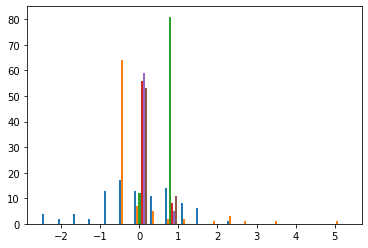

In [10]:
plt.hist(x_bdnf, 20);

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [bdnf_predictor_continue_missing, bdnf_chol, _bdnf_raw, Xmu_bdnf]
>BinaryGibbsMetropolis: [bdnf_predictor_binary_missing]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 110 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


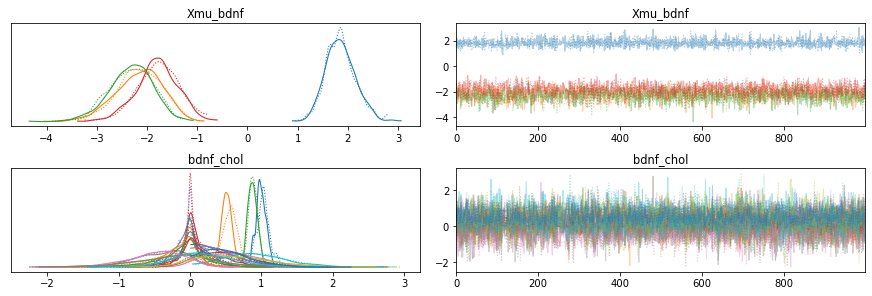

In [11]:
with pm.Model() as m_bdnf:
    Xmu_bdnf = pm.Normal('Xmu_bdnf', mu=0, sigma=1, 
                         shape=(X_bdnf_train.shape[-1] - 2, 1))
    _bdnf_raw = pm.Normal('_bdnf_raw', mu=0, sigma=1,
                          shape=(X_bdnf_train.shape[-1], X_bdnf_train.shape[0]))
    bdnf_chol, *_ = pm.LKJCholeskyCov(
        "bdnf_chol", 
        n=X_bdnf_train.shape[-1], eta=1.0, sd_dist=pm.HalfNormal.dist(1.0),
        compute_corr=True, store_in_trace=False
    )
    Xmu_bdnf_ = tt.concatenate([tt.zeros([2, 1]), Xmu_bdnf], axis=0)
    bdnf_rotated = (Xmu_bdnf_ + tt.dot(bdnf_chol, _bdnf_raw)).T
    bdnf_predictor_continue = pm.Normal(
        'bdnf_predictor_continue',
        mu=bdnf_rotated[:, :2], sigma=.05,
        observed=X_bdnf_train[:, :2])
    bdnf_predictor_binary = pm.Bernoulli(
        'bdnf_predictor_binary',
        logit_p=bdnf_rotated[:, 2:],
        observed=X_bdnf_train[:, 2:])
    trace = pm.sample()
pm.traceplot(trace, var_names=['Xmu_bdnf', 'bdnf_chol']);

In [12]:
np.nanmean(x_syn, axis=0), np.nanstd(x_syn, axis=0)

(array([-2.65127886e-17,  5.30255773e-17]), array([1., 1.]))

In [13]:
np.corrcoef(x_syn[~np.any(x_syn_missing, axis=1), :].T)

array([[1.        , 0.36815438],
       [0.36815438, 1.        ]])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [syn_predictor_missing, syn_chol]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.


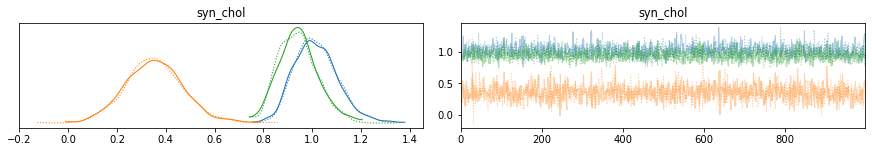

In [14]:
with pm.Model() as m_syn:
    syn_chol, *_ = pm.LKJCholeskyCov(
        "syn_chol", 
        n=X_syn_train.shape[-1], eta=1.0, sd_dist=pm.HalfNormal.dist(1.0),
        compute_corr=True, store_in_trace=False
    )
    syn_predictor = pm.MvNormal(
        'syn_predictor',
        mu=0., chol=syn_chol,
        observed=X_syn_train)
    trace = pm.sample()
pm.traceplot(trace, var_names=['syn_chol']);

In [15]:
np.nanmean(x_nnf, axis=0), np.nanstd(x_nnf, axis=0)

(array([-3.06602289e-17, -1.96870943e-17,  7.02672800e-18]),
 array([1., 1., 1.]))

In [16]:
np.corrcoef(x_nnf[~np.any(x_nnf_missing, axis=1), :].T)

array([[1.        , 0.98426579, 0.98154409],
       [0.98426579, 1.        , 0.99919465],
       [0.98154409, 0.99919465, 1.        ]])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nnf_predictor_missing, nnf_chol]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 164 seconds.


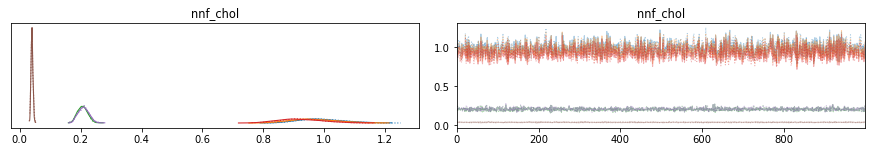

In [17]:
with pm.Model() as m_nnf:
    nnf_chol, *_ = pm.LKJCholeskyCov(
        "nnf_chol", 
        n=X_nnf_train.shape[-1], eta=.5, sd_dist=pm.HalfNormal.dist(1.0),
        compute_corr=True, store_in_trace=False
    )
    nnf_predictor = pm.MvNormal(
        'nnf_predictor',
        mu=0., chol=nnf_chol,
        observed=X_nnf_train)
    trace = pm.sample()
pm.traceplot(trace, var_names=['nnf_chol']);

### Define and fit the model

In [18]:
with pm.Model() as hierar_model:
    #Define hyperpriors
    mu_beta = pm.Normal('mu_beta', mu=0, sd=0.01) 
    sd_beta = pm.HalfNormal('sd_beta', sd=5)
    #Define priors
    beta_bdnf = pm.Normal('beta_bdnf', mu=mu_beta, sd=sd_beta, shape=(6,1))
    beta_syn = pm.Normal('beta_syn', mu=mu_beta, sd=sd_beta, shape=(2,1))
    beta_nnf = pm.Normal('beta_nnf', mu=mu_beta, sd=sd_beta, shape=(3,1))

In [19]:
# ## Define bndf 
with hierar_model:
    # Imputation of X missing values for BDNF
    Xmu_bdnf = pm.Normal('Xmu_bdnf', mu=0, sigma=1, 
                         shape=(X_bdnf_train.shape[-1] - 2, 1))
    _bdnf_raw = pm.Normal('_bdnf_raw', mu=0, sigma=1,
                          shape=(X_bdnf_train.shape[-1], X_bdnf_train.shape[0]))
    bdnf_chol, *_ = pm.LKJCholeskyCov(
        "bdnf_chol", 
        n=X_bdnf_train.shape[-1], eta=1.0, sd_dist=pm.HalfNormal.dist(1.0),
        compute_corr=True, store_in_trace=False
    )
    Xmu_bdnf_ = tt.concatenate([tt.zeros([2, 1]), Xmu_bdnf], axis=0)
    bdnf_rotated = (Xmu_bdnf_ + tt.dot(bdnf_chol, _bdnf_raw)).T
    bdnf_predictor_continue = pm.Normal(
        'bdnf_predictor_continue',
        mu=bdnf_rotated[:, :2], sigma=.05,
        observed=X_bdnf_train[:, :2])
    bdnf_predictor_binary = pm.Bernoulli(
        'bdnf_predictor_binary',
        logit_p=bdnf_rotated[:, 2:],
        observed=X_bdnf_train[:, 2:])
    
    X_bdnf_modelled = tt.concatenate(
        [bdnf_predictor_continue, bdnf_predictor_binary],
        axis=-1
    )

    # Likelihood for BDNF
    #SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf = pm.Deterministic('lp_bdnf', tt.dot(X_bdnf_modelled, beta_bdnf))
    y_obs_bdnf = pm.Bernoulli('y_obs_bdnf', logit_p=lp_bdnf, observed=Y_bdnf_train)

In [20]:
# ## Define syn
with hierar_model:
    # Imputation of X missing values for Syn
    syn_chol, *_ = pm.LKJCholeskyCov(
        "syn_chol", 
        n=X_syn_train.shape[-1], eta=1.0, sd_dist=pm.HalfNormal.dist(1.0),
        compute_corr=True, store_in_trace=False
    )
    X_syn_modelled = pm.MvNormal(
        'X_syn_modelled',
        mu=0., chol=syn_chol,
        observed=X_syn_train)
   
    # Likelihood for Syn
    #BDNF->SYN
    lp_syn =  pm.Deterministic('lp_syn', lp_bdnf + tt.dot(X_syn_modelled, beta_syn))    
    y_obs_syn = pm.Bernoulli("y_obs_syn", logit_p=lp_syn, observed=Y_syn_train)

In [21]:
# ## Define nnf
with hierar_model:
    # Imputation of X missing values for NNF
    nnf_chol, *_ = pm.LKJCholeskyCov(
        "nnf_chol", 
        n=X_nnf_train.shape[-1], eta=.5, sd_dist=pm.HalfNormal.dist(1.0),
        compute_corr=True, store_in_trace=False
    )
    X_nnf_modelled = pm.MvNormal(
        'X_nnf_modelled',
        mu=0., chol=nnf_chol,
        observed=X_nnf_train)
   
    # Likelihood for NNF
    #BDNF->SYN->NNF
    lp_nnf = pm.Deterministic('lp_nnf', lp_syn + tt.dot(X_nnf_modelled, beta_nnf))
    y_obs_nnf = pm.Bernoulli("y_obs_nnf", logit_p=lp_nnf, observed=Y_nnf_train)

In [22]:
# ## Define DNT
with hierar_model:
    #Define causal relationships for DNT
    lp_dnt = pm.Deterministic('lp_dnt', lp_bdnf + lp_syn + lp_nnf)
    y_obs_dnt = pm.Bernoulli('y_obs_dnt', logit_p=lp_dnt, observed=Y_dnt_train)

In [23]:
#Checking the proposed structure of model
hierar_model.check_test_point()

mu_beta                                3.69
sd_beta_log__                         -0.77
beta_bdnf                            -13.82
beta_syn                              -4.61
beta_nnf                              -6.91
Xmu_bdnf                              -3.68
_bdnf_raw                           -534.82
bdnf_chol_cholesky-cov-packed__       -0.92
bdnf_predictor_continue_missing        0.00
bdnf_predictor_binary_missing          0.00
y_obs_bdnf_missing                     0.00
syn_chol_cholesky-cov-packed__        -0.76
X_syn_modelled_missing                 0.00
nnf_chol_cholesky-cov-packed__         0.35
X_nnf_modelled_missing                 0.00
bdnf_predictor_continue           -35997.10
bdnf_predictor_binary               -268.94
y_obs_bdnf                           -67.24
X_syn_modelled                      -245.27
y_obs_syn                            -67.24
X_nnf_modelled                      -392.91
y_obs_nnf                            -67.24
y_obs_dnt                       

In [24]:
#Compute prior distribution

#ERROR related to shape

# with hierar_model:
#     prior_all = pm.sample_prior_predictive(1000)

In [25]:
#Make the inferences
with hierar_model:
    trace = pm.sample(cores=4, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [X_nnf_modelled_missing, nnf_chol, X_syn_modelled_missing, syn_chol, bdnf_predictor_continue_missing, bdnf_chol, _bdnf_raw, Xmu_bdnf, beta_nnf, beta_syn, beta_bdnf, sd_beta, mu_beta]
>BinaryGibbsMetropolis: [bdnf_predictor_binary_missing, y_obs_bdnf_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 756 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [26]:
#Compute posterior distributions
# with hierar_model:
#     posterior_all = pm.sample_posterior_predictive(trace)

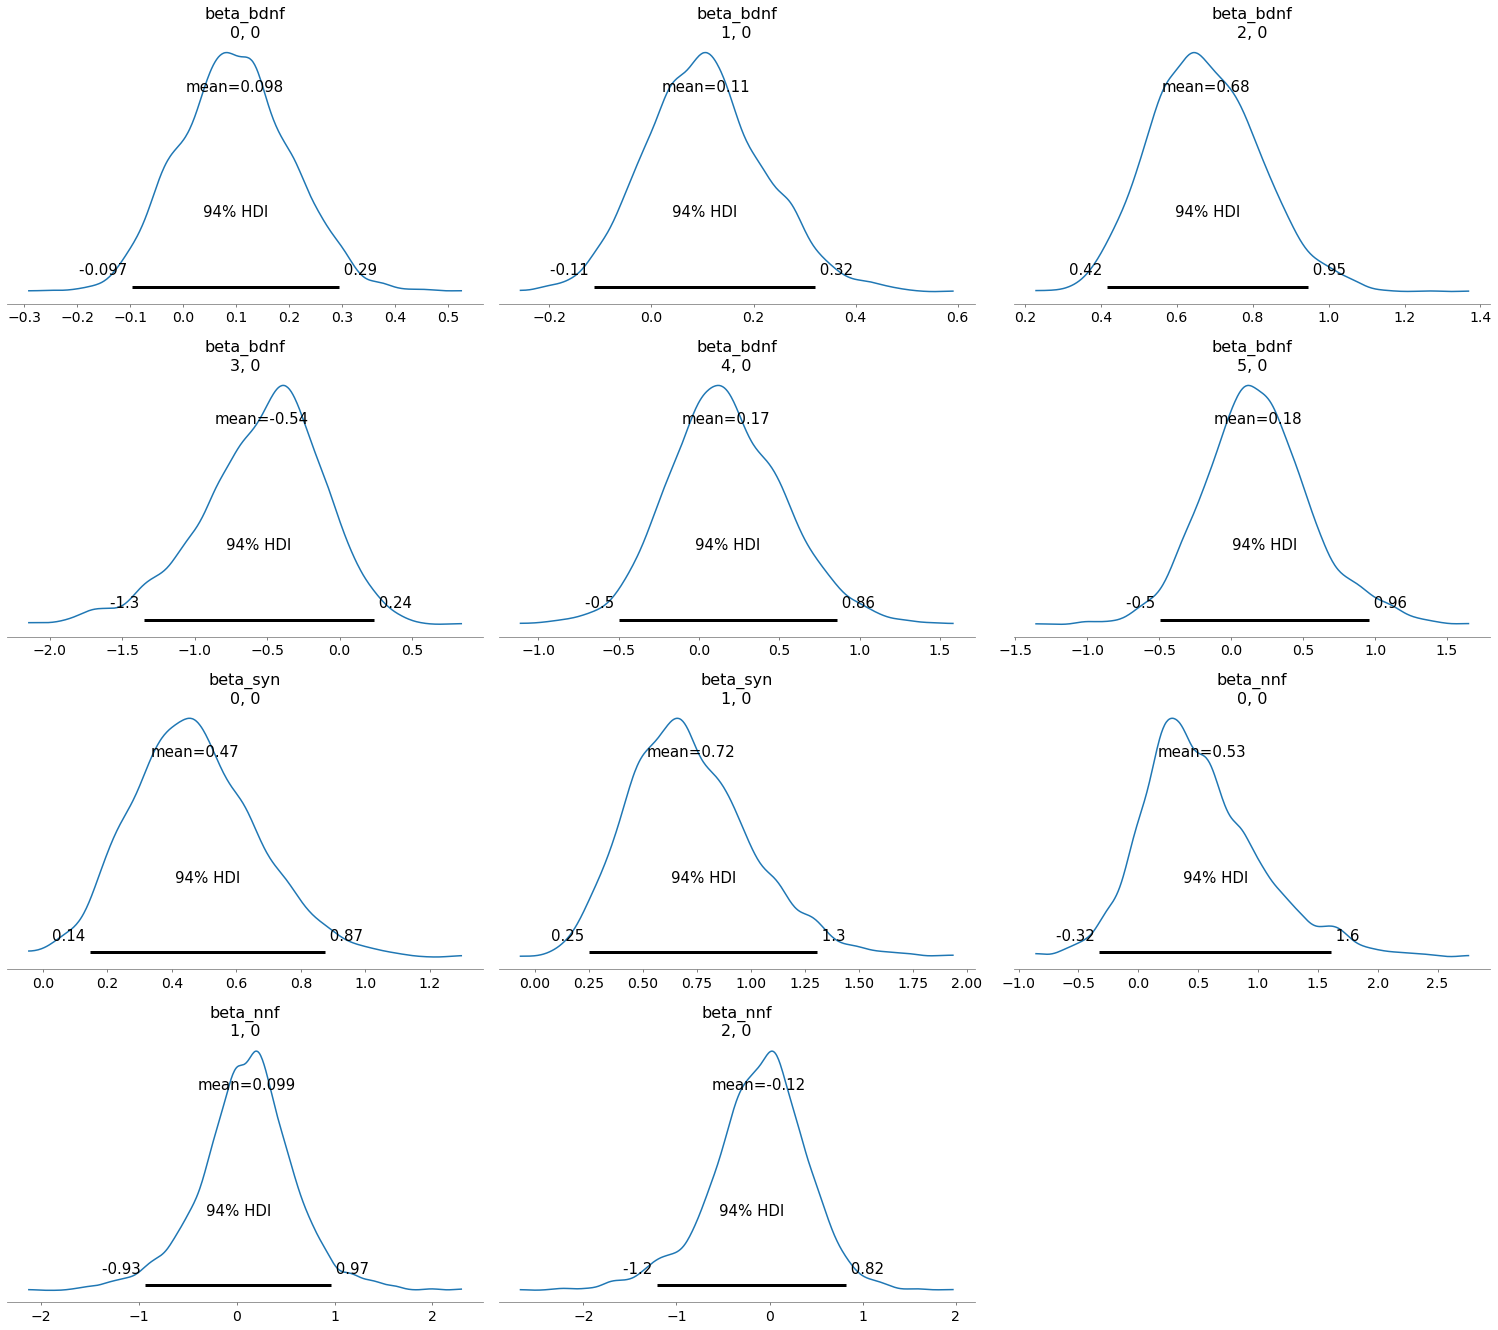

In [43]:
#Checking the posterior
pm.plot_posterior(trace, var_names=['beta_bdnf', 'beta_syn', 'beta_nnf']);

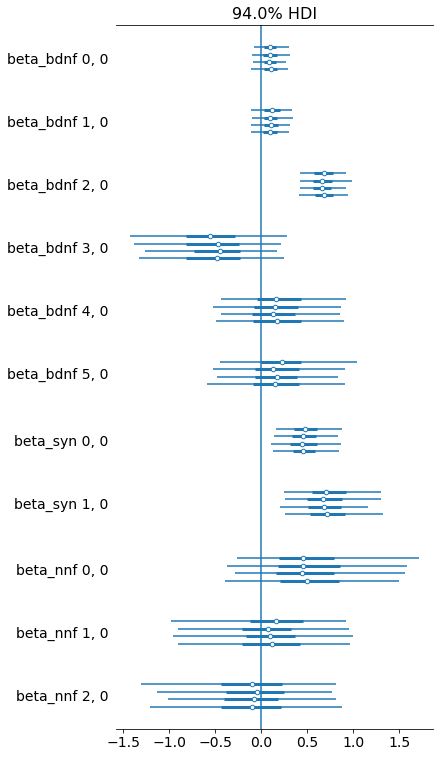

In [52]:
ax = pm.forestplot(trace, var_names=['beta_bdnf', 'beta_syn', 'beta_nnf']);
ax[0].vlines(0., *ax[0].get_ylim());

### Model checking

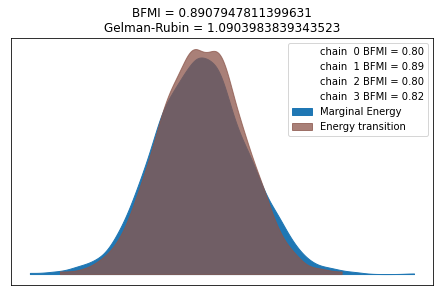

In [29]:
#Check the energy plot
bfmi = np.max(pm.stats.bfmi(trace))
max_gr = max(np.max(gr_stats) for gr_stats in pm.stats.rhat(trace).values()).values
(pm.energyplot(trace, legend=True, figsize=(6, 4))
   .set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

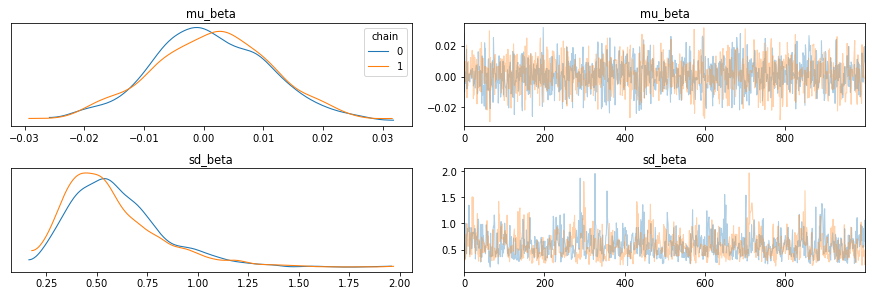

In [30]:
#Check convergence for hyperpriors of two chains
az.plot_trace(trace, var_names=['mu_beta', 'sd_beta'],
             coords={"chain":[0,1]}, legend=True)
#plt.suptitle("Trace plots")
plt.show()

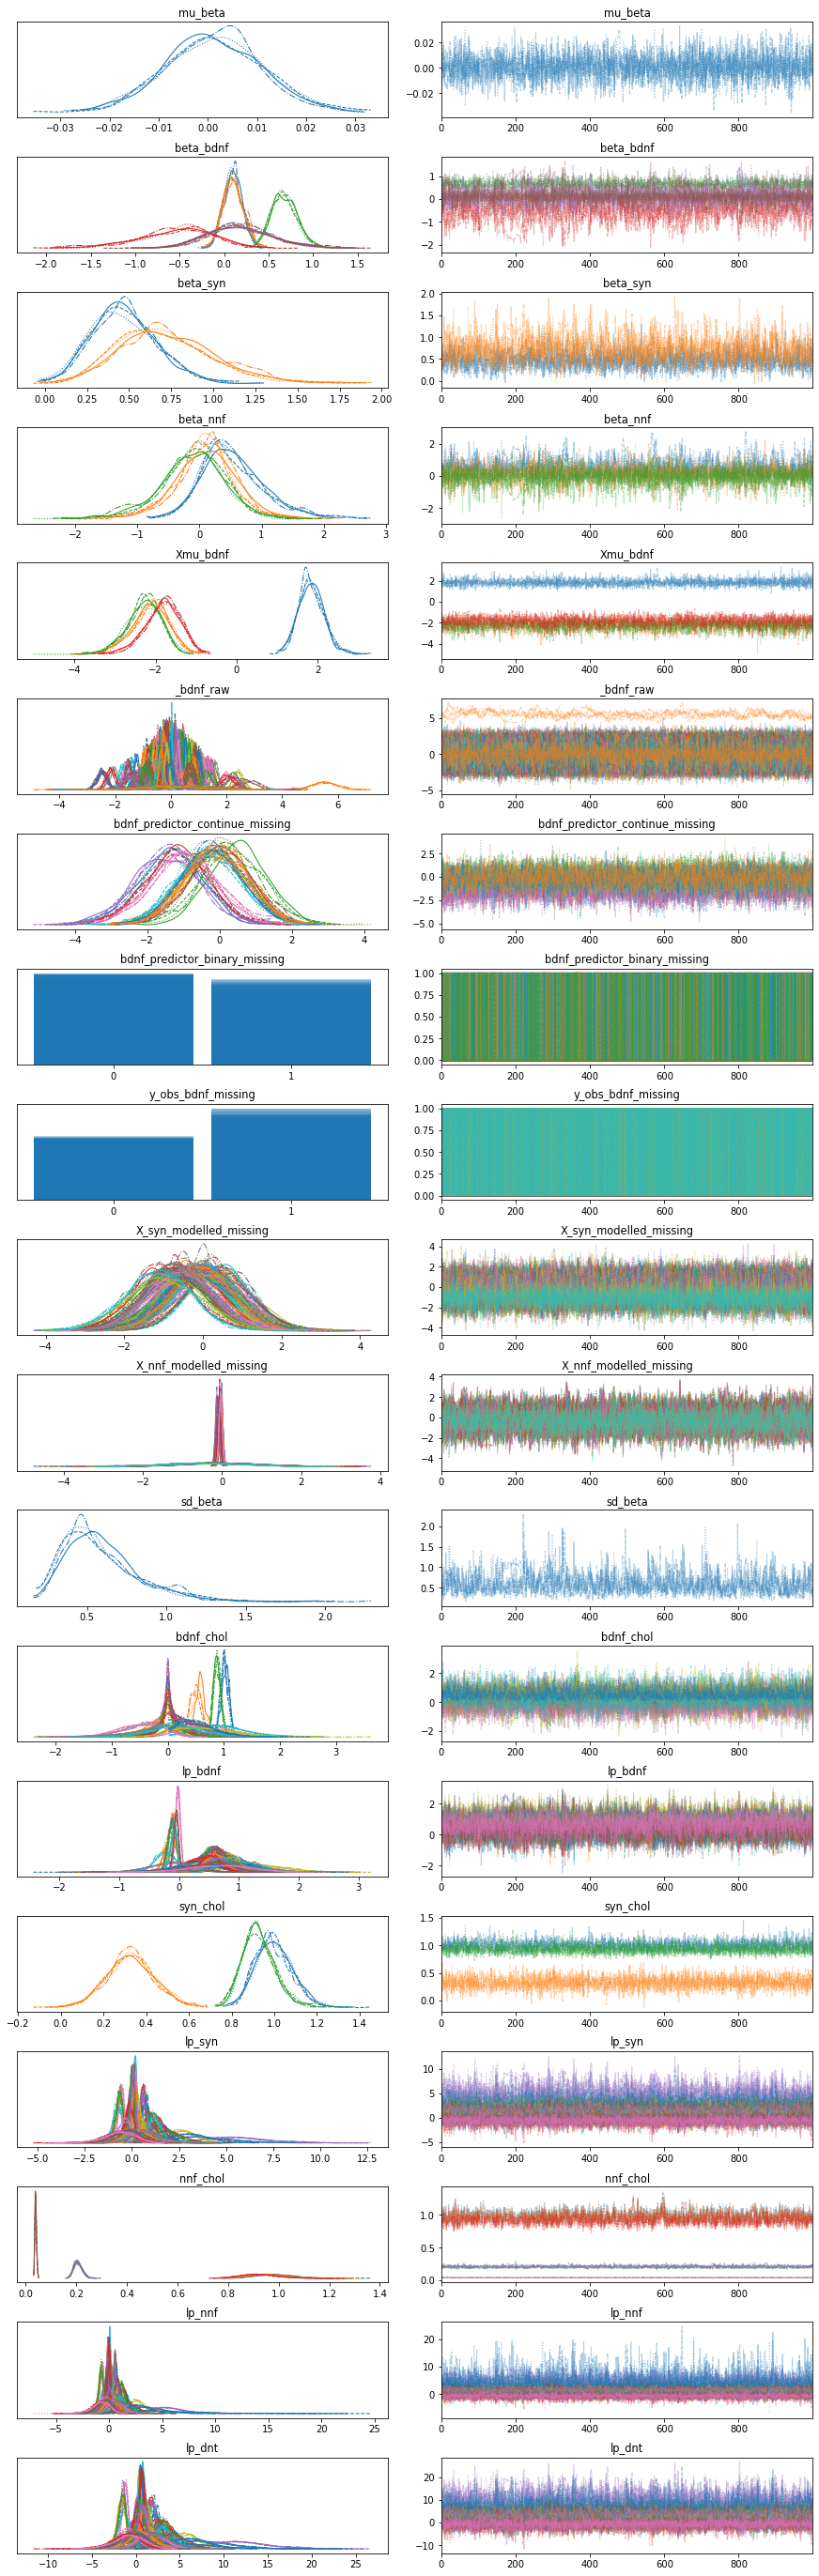

In [31]:
#Check the convergence of all parameters
pm.traceplot(trace);

### Checking statistics

In [32]:
#Statistical summary
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_beta,0.001,0.010,-0.018,0.019,0.000,0.000,3349.0,1544.0,3381.0,1993.0,1.00
"beta_bdnf[0,0]",0.098,0.106,-0.097,0.294,0.002,0.002,1976.0,1578.0,2004.0,2678.0,1.00
"beta_bdnf[1,0]",0.106,0.117,-0.113,0.321,0.003,0.002,1412.0,1412.0,1415.0,2266.0,1.00
"beta_bdnf[2,0]",0.676,0.143,0.417,0.946,0.004,0.003,1075.0,1075.0,1086.0,1963.0,1.00
"beta_bdnf[3,0]",-0.538,0.424,-1.349,0.238,0.021,0.019,413.0,254.0,526.0,236.0,1.01
...,...,...,...,...,...,...,...,...,...,...,...
"lp_dnt[92,0]",-0.094,1.535,-3.148,2.571,0.031,0.022,2448.0,2361.0,2469.0,2114.0,1.00
"lp_dnt[93,0]",-1.254,1.722,-4.636,1.743,0.036,0.025,2347.0,2347.0,2428.0,2410.0,1.00
"lp_dnt[94,0]",-0.032,1.520,-2.902,2.818,0.028,0.023,3047.0,2233.0,3121.0,2947.0,1.00
"lp_dnt[95,0]",-0.167,1.529,-3.126,2.565,0.028,0.025,2995.0,1945.0,3323.0,3010.0,1.00


In [33]:
#Helper function
def convergence_hist(hist_data):
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.hist(hist_data, bins=50, color="#1f77b4", ec="#3d5167", alpha=0.9, lw=1.2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.yticks(ticks=None)

    return fig, ax

In [34]:
#R-hat
def check_rhat(inf_data, threshold=1.1, verbose=True):
    s = az.summary(inf_data, round_to="none")
    fig, ax = convergence_hist(s["r_hat"])
    #ax.set_xlabel("Rhat statistic", labelpad=15)
    ax.set_title("$\hat{R}$")

    bad = s[s["r_hat"] > threshold]
    if len(bad) == 0:
        text = "None"
    else:
        text = list(bad.index)
        ax.axvline(x=threshold, c="#3d5167", lw=2)
    if verbose:
        print(f"The following parameters have an Rhat greater {threshold}:\n{text}\n")
    return fig, ax

The following parameters have an Rhat greater 1.05:
['_bdnf_raw[0,10]', '_bdnf_raw[0,18]', '_bdnf_raw[0,23]', '_bdnf_raw[0,24]', '_bdnf_raw[0,28]', '_bdnf_raw[0,29]', '_bdnf_raw[0,30]', '_bdnf_raw[0,33]', '_bdnf_raw[0,35]', '_bdnf_raw[0,36]', '_bdnf_raw[0,37]', '_bdnf_raw[0,40]', '_bdnf_raw[0,49]', '_bdnf_raw[0,54]', '_bdnf_raw[0,55]', '_bdnf_raw[0,60]', '_bdnf_raw[0,63]', '_bdnf_raw[0,76]', '_bdnf_raw[0,77]', '_bdnf_raw[0,87]', '_bdnf_raw[0,96]', '_bdnf_raw[1,0]', '_bdnf_raw[1,5]', '_bdnf_raw[1,7]', '_bdnf_raw[1,8]', '_bdnf_raw[1,10]', '_bdnf_raw[1,13]', '_bdnf_raw[1,16]', '_bdnf_raw[1,17]', '_bdnf_raw[1,19]', '_bdnf_raw[1,23]', '_bdnf_raw[1,29]', '_bdnf_raw[1,30]', '_bdnf_raw[1,36]', '_bdnf_raw[1,37]', '_bdnf_raw[1,38]', '_bdnf_raw[1,40]', '_bdnf_raw[1,48]', '_bdnf_raw[1,49]', '_bdnf_raw[1,51]', '_bdnf_raw[1,54]', '_bdnf_raw[1,55]', '_bdnf_raw[1,57]', '_bdnf_raw[1,66]', '_bdnf_raw[1,67]', '_bdnf_raw[1,68]', '_bdnf_raw[1,75]', '_bdnf_raw[1,76]', '_bdnf_raw[1,77]', '_bdnf_raw[1,87]', '

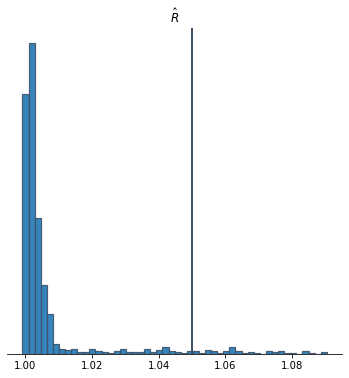

In [35]:
check_rhat(trace, threshold=1.05) #1.005 also considered
plt.show()

In [36]:
#MCSE
def check_mcse(inf_data, threshold=0.1, verbose=True):
    s = az.summary(inf_data, round_to="none")
    hist_data = s["mcse_mean"] / s["sd"]
    fig, ax = convergence_hist(hist_data)
    #ax.set_xlabel("Monte Carlo standard error / posterior sd", labelpad=15)
    ax.set_title("Monte Carlo Standard Error/Posterior sd")
    ax.locator_params(axis='x', nbins=5)

    bad = s[hist_data > threshold]
    if len(bad) == 0:
        text = "None"
    else:
        text = list(bad.index)
        ax.axvline(x=threshold, c="#3d5167", lw=2)
    if verbose:
        print(
            f"The following parameters have a Monte Carlo standard error greater than {threshold * 100}% of the posterior standard deviation:\n{text}\n")
    return fig, ax

The following parameters have a Monte Carlo standard error greater than 10.0% of the posterior standard deviation:
['_bdnf_raw[0,0]', '_bdnf_raw[0,5]', '_bdnf_raw[0,7]', '_bdnf_raw[0,10]', '_bdnf_raw[0,14]', '_bdnf_raw[0,18]', '_bdnf_raw[0,19]', '_bdnf_raw[0,23]', '_bdnf_raw[0,24]', '_bdnf_raw[0,28]', '_bdnf_raw[0,29]', '_bdnf_raw[0,30]', '_bdnf_raw[0,33]', '_bdnf_raw[0,35]', '_bdnf_raw[0,36]', '_bdnf_raw[0,37]', '_bdnf_raw[0,38]', '_bdnf_raw[0,40]', '_bdnf_raw[0,48]', '_bdnf_raw[0,49]', '_bdnf_raw[0,51]', '_bdnf_raw[0,54]', '_bdnf_raw[0,55]', '_bdnf_raw[0,57]', '_bdnf_raw[0,58]', '_bdnf_raw[0,59]', '_bdnf_raw[0,60]', '_bdnf_raw[0,63]', '_bdnf_raw[0,66]', '_bdnf_raw[0,67]', '_bdnf_raw[0,75]', '_bdnf_raw[0,76]', '_bdnf_raw[0,77]', '_bdnf_raw[0,87]', '_bdnf_raw[0,90]', '_bdnf_raw[0,95]', '_bdnf_raw[0,96]', '_bdnf_raw[1,0]', '_bdnf_raw[1,1]', '_bdnf_raw[1,3]', '_bdnf_raw[1,5]', '_bdnf_raw[1,6]', '_bdnf_raw[1,7]', '_bdnf_raw[1,8]', '_bdnf_raw[1,10]', '_bdnf_raw[1,12]', '_bdnf_raw[1,13]', '

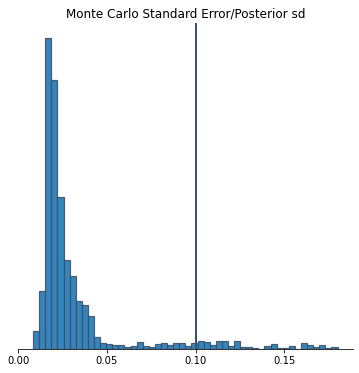

In [37]:
check_mcse(trace)
plt.show()

In [38]:
#Error related to the shape of bdnf


#ESS/NEFF, number of effective sample size
def check_neff(inf_data, threshold=0.1, verbose=True):
    N = inf_data.posterior.dims['chain'] * inf_data.posterior.dims['draw']
    s = az.summary(inf_data, round_to="none")
    fig, ax = convergence_hist(s["ess_mean"] / N)
    #ax.set_xlabel("Effective sample size / iterations", labelpad=15)
    ax.set_title("$n_{eff}/N$")

    bad = s[s["ess_mean"] / N < threshold]
    if len(bad) == 0:
        text = "None"
    else:
        text = list(bad.index)
        ax.axvline(x=threshold, c="#3d5167", lw=2)
    if verbose:
        print(
            f"The following parameters have an effective sample size less than {threshold * 100}% of the total sample size:\n{text}\n")
    return fig, ax

The following parameters have an effective sample size less than 10.0% of the total sample size:
['_bdnf_raw[0,0]', '_bdnf_raw[0,1]', '_bdnf_raw[0,3]', '_bdnf_raw[0,4]', '_bdnf_raw[0,5]', '_bdnf_raw[0,6]', '_bdnf_raw[0,7]', '_bdnf_raw[0,8]', '_bdnf_raw[0,9]', '_bdnf_raw[0,10]', '_bdnf_raw[0,12]', '_bdnf_raw[0,13]', '_bdnf_raw[0,14]', '_bdnf_raw[0,16]', '_bdnf_raw[0,17]', '_bdnf_raw[0,18]', '_bdnf_raw[0,19]', '_bdnf_raw[0,20]', '_bdnf_raw[0,21]', '_bdnf_raw[0,22]', '_bdnf_raw[0,23]', '_bdnf_raw[0,24]', '_bdnf_raw[0,25]', '_bdnf_raw[0,26]', '_bdnf_raw[0,27]', '_bdnf_raw[0,28]', '_bdnf_raw[0,29]', '_bdnf_raw[0,30]', '_bdnf_raw[0,32]', '_bdnf_raw[0,33]', '_bdnf_raw[0,35]', '_bdnf_raw[0,36]', '_bdnf_raw[0,37]', '_bdnf_raw[0,38]', '_bdnf_raw[0,39]', '_bdnf_raw[0,40]', '_bdnf_raw[0,44]', '_bdnf_raw[0,45]', '_bdnf_raw[0,48]', '_bdnf_raw[0,49]', '_bdnf_raw[0,50]', '_bdnf_raw[0,51]', '_bdnf_raw[0,52]', '_bdnf_raw[0,54]', '_bdnf_raw[0,55]', '_bdnf_raw[0,57]', '_bdnf_raw[0,58]', '_bdnf_raw[0,59]',

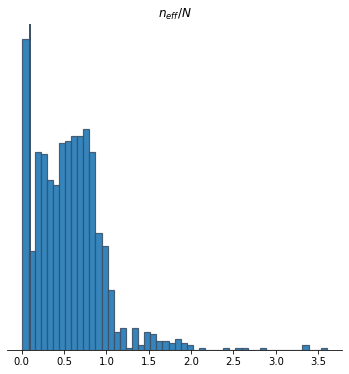

In [39]:
check_neff(trace)
plt.show()

### Goodness of fit

In [40]:
#Plot the observed vs simulated and mean

#ERROR related to strace or report

# data = az.from_pymc3(trace, posterior_predictive=posterior_all, model = hierar_model) #prior=prior_all
# az.plot_ppc(data);

### Predictions

In [41]:
bdnf = trace['y_obs_bdnf']
syn = trace['']
nnf = trace['']
dnt = trace['']

TypeError: 'InferenceData' object is not subscriptable

In [ ]:
#Helper function
def logistic(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
post_bdnf = logistic(bdnf)
post_syn
post_nnf
post_dnt


In [ ]:

#https://seaborn.pydata.org/examples/pairgrid_dotplot.html
    

### Save the graphical structure, stats and traces

In [ ]:
#Save the graphical structure of the model
graph = pm.model_to_graphviz(hierar_model)
graph.render('hierar_model_structure.gv', view=True)

In [ ]:
#Save the statistical summary of the trace
file = az.summary(trace, round_to=None)
file.to_csv('Statistical_summary_trace.csv')

In [ ]:
#Have to finalise this if it remains useful
dnt_data = az.from_pymc3(trace=trace,
                     prior=prior,
                     posterior_predictive=posterior,
                    )
dnt_data.to_netcdf("dnt_hier.nc")

In [ ]:
#Save the traces
pm.save_trace(trace, directory='dnt_trace.nc')

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w